## ZFit 
Returns weights for centrality 0, 1 or 2 (0-10,10-40,40-80 %)

Important : (D0mass > 1.75) & (D0mass<2.0) cuts should be always applied


In [1]:
import mplhep
import numpy as np
import zfit
from matplotlib import pyplot as plt
import uproot
from hepstats.splot import compute_sweights

D0massCut = "& (D0mass > 1.75) & (D0mass<2.0)"
obs = zfit.Space('D0mass', limits=(1.75, 2.0))
mu = zfit.Parameter("mu", 1.865, 1.8, 1.92, step_size=0.0001)
sigma = zfit.Parameter("sigma", 0.02, 0.001, 0.3, step_size=0.0001)
lambd = zfit.Parameter("lambda", -3.0)
sig_yield = zfit.Parameter('sig_yield', 5300, 0, 100000,
                                step_size=10)  # step size: default is small, use appropriate
bkg_yield = zfit.Parameter('bkg_yield', 25000, 0, 3e5, step_size=10)


centrality=0
centralityCut=""
if (centrality ==0):
    centralityCut = "(centrality==8)"
elif (centrality ==1):
    centralityCut = "(centrality>=5)&( centrality<8) "
elif (centrality ==2):
    centralityCut = "(centrality <5)"
else:
    print("Wrong centrality")

with uproot.open("/home/prozorov/dev/star/D0_jets_2014_231030.root") as exp_file:
          exp_tree = exp_file['Jets']
          exp = exp_tree.arrays(["D0mass","jet_pt_corr"], cut=centralityCut + D0massCut,library='pd')
    
def getSWeights(exp):
# model building, pdf creation
    signal_pdf  = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
    comb_bkg_pdf  = zfit.pdf.Exponential(lambd, obs=obs)

    data= zfit.Data.from_pandas(exp)

# Create the extended models
    extended_sig = signal_pdf.create_extended(sig_yield)
    extended_bkg = comb_bkg_pdf.create_extended(bkg_yield)

# The final model is the combination of the signal and backgrond PDF
    model = zfit.pdf.SumPDF([extended_bkg, extended_sig])

# plot the data
    data_mass = data["D0mass"].numpy()

# Builds the loss.
    data_sw = zfit.Data.from_numpy(obs=obs, array=data_mass)
    nll_sw = zfit.loss.ExtendedUnbinnedNLL(model, data_sw)

# This parameter was useful in the simultaneous fit but not anymore so we fix it.
    sigma.floating = False

# Minimizes the loss.
    minimizer = zfit.minimize.Minuit(use_minuit_grad=True)
    result_sw = minimizer.minimize(nll_sw)
   
    weights = compute_sweights(model, data_sw)
    return weights[sig_yield]



/home/prozorov/install/miniconda3/envs/tf/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


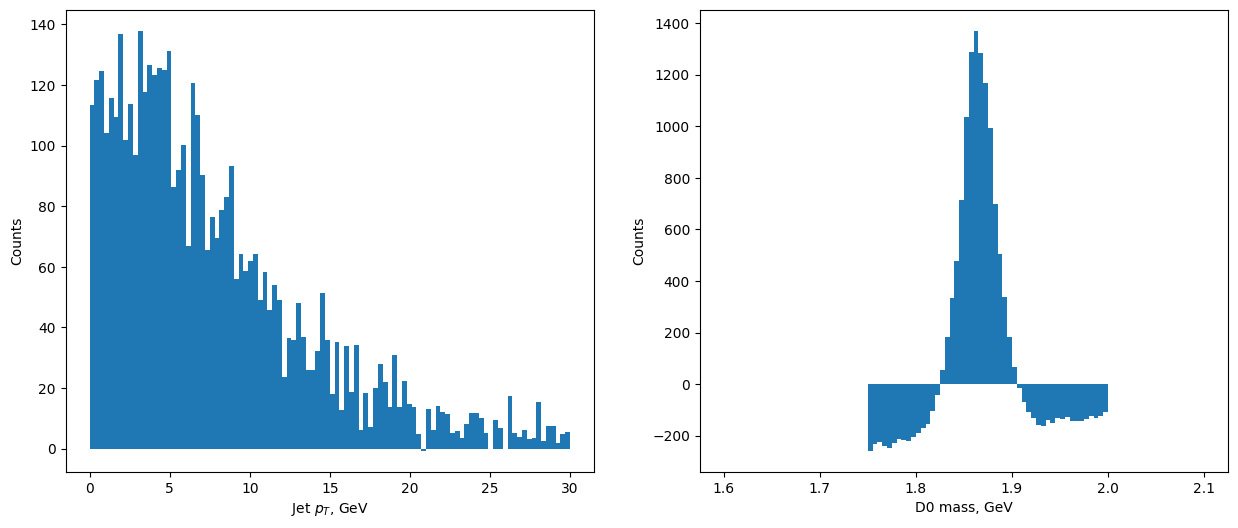

In [2]:

sWeights=getSWeights(exp)

plt.figure(figsize=[15, 6])
plt.subplot(1, 2, 1)
plt.hist(exp['jet_pt_corr'], bins=100,weights=sWeights, range=(0, 30))
plt.xlabel("Jet $p_T$, GeV")
plt.ylabel("Counts")
plt.subplot(1, 2, 2)
plt.hist(exp['D0mass'], bins=100,weights=sWeights, range=(1.6, 2.1))
plt.xlabel("D0 mass, GeV")
plt.ylabel("Counts")
plt.show()